## > CO7113 AI for Space 2024-25 SEM2: Assignment 3: Group Research Project

## > Title - Application of CNN Models to Remote Sensing Using Satellite Imagery: Land Cover Classification Using MobileNetV2 on EuroSAT RGB Dataset

## > Group - 25

## > Import libraries

In [ ]:
import os
import shutil
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

## > Clone the Dataset

In [ ]:
# Download the dataset from GitHub if not already present
if not os.path.exists('EuroSAT-LULC-Dataset'):
    !git clone https://github.com/TheAamirNasir/EuroSAT-LULC-Dataset.git

## > Clean Dataset

In [ ]:
# Function to remove non-image files and hidden files from dataset folders
def clean_dataset_folder(root_dir):
    valid_exts = ('.jpg', '.jpeg', '.png')
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if not file.lower().endswith(valid_exts) or file.startswith('.'):
                os.remove(os.path.join(root, file))
        for dir_name in dirs:
            if dir_name.startswith('.'):
                shutil.rmtree(os.path.join(root, dir_name))

data_dir = '/content/EuroSAT-LULC-Dataset/EuroSAT_RGB'
clean_dataset_folder(data_dir)

## > Transformations

In [ ]:
# Transformations like: resize, random flip, random rotation, tensor conversion, and normalization
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## > Load full dataset

In [ ]:
# Load the dataset using ImageFolder and apply transformations
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

## > Split dataset (70% train, 15% val, 15% test)

In [ ]:
# Randomly split dataset into training, validation, and testing sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

## > DataLoaders

In [ ]:
# Create DataLoaders to feed data to the model in batches
train_loader = DataLoader(train_ds, batch_size=64, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=2, pin_memory=True)

## > Load Pretrained MobileNetV2

In [ ]:
# Load MobileNetV2 pretrained on ImageNet, and adjust the final layer to match number of classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mobilenet_v2(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

## > Loss and Optimizer

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

## > Train

In [ ]:
# Train the model for a set number of epochs
epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct_preds, total_preds = 0, 0, 0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = outputs.argmax(1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
            pbar.set_postfix(loss=loss.item(), accuracy=100*correct_preds/total_preds)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_preds / total_preds

    # Validation after each epoch
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")

Epoch 1/10: 100%|██████████| 296/296 [05:12<00:00,  1.05s/it, accuracy=88.7, loss=0.547]


Epoch 1: Train Loss=0.3401, Val Loss=0.1447, Train Acc=88.69%, Val Acc=95.26%


Epoch 2/10: 100%|██████████| 296/296 [05:07<00:00,  1.04s/it, accuracy=94.1, loss=0.255]


Epoch 2: Train Loss=0.1767, Val Loss=0.1232, Train Acc=94.12%, Val Acc=95.83%


Epoch 3/10: 100%|██████████| 296/296 [05:00<00:00,  1.02s/it, accuracy=95.1, loss=0.196]


Epoch 3: Train Loss=0.1431, Val Loss=0.1284, Train Acc=95.08%, Val Acc=95.56%


Epoch 4/10: 100%|██████████| 296/296 [05:02<00:00,  1.02s/it, accuracy=95.9, loss=0.408]


Epoch 4: Train Loss=0.1232, Val Loss=0.1241, Train Acc=95.88%, Val Acc=96.10%


Epoch 5/10: 100%|██████████| 296/296 [04:59<00:00,  1.01s/it, accuracy=96.4, loss=0.144]


Epoch 5: Train Loss=0.1072, Val Loss=0.1246, Train Acc=96.39%, Val Acc=95.75%


Epoch 6/10: 100%|██████████| 296/296 [05:04<00:00,  1.03s/it, accuracy=96.9, loss=0.0483]


Epoch 6: Train Loss=0.0868, Val Loss=0.1197, Train Acc=96.95%, Val Acc=96.67%


Epoch 7/10: 100%|██████████| 296/296 [05:04<00:00,  1.03s/it, accuracy=97.2, loss=0.237]


Epoch 7: Train Loss=0.0852, Val Loss=0.1482, Train Acc=97.19%, Val Acc=95.75%


Epoch 8/10: 100%|██████████| 296/296 [05:02<00:00,  1.02s/it, accuracy=97.2, loss=0.146]


Epoch 8: Train Loss=0.0798, Val Loss=0.2286, Train Acc=97.22%, Val Acc=94.12%


Epoch 9/10: 100%|██████████| 296/296 [05:02<00:00,  1.02s/it, accuracy=97.5, loss=0.172]


Epoch 9: Train Loss=0.0751, Val Loss=0.1130, Train Acc=97.49%, Val Acc=96.57%


Epoch 10/10: 100%|██████████| 296/296 [05:03<00:00,  1.03s/it, accuracy=98, loss=0.00337]


Epoch 10: Train Loss=0.0603, Val Loss=0.0980, Train Acc=97.95%, Val Acc=97.04%


## > Plotting

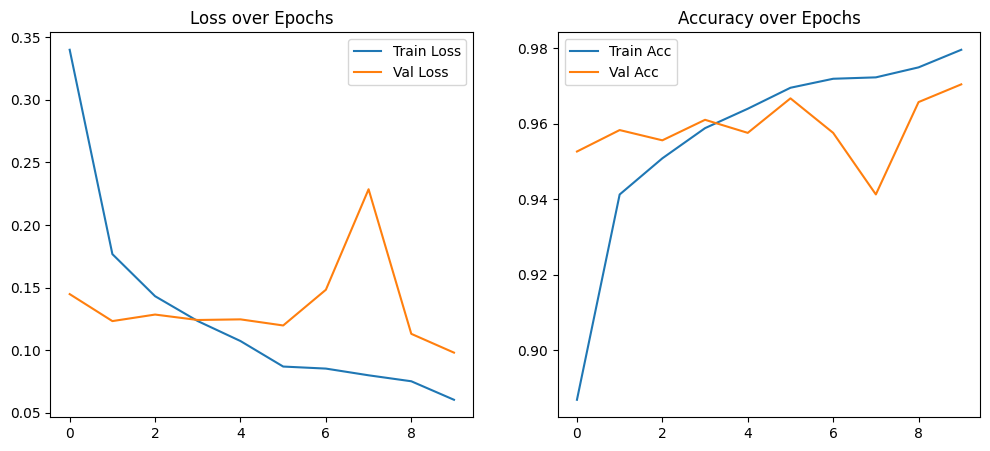

In [ ]:
# Plot loss and accuracy curves for both training and validation sets
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

## > Classification Report

In [ ]:
# Evaluate the model on test data and print classification metrics
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.91      0.94       472
              Forest       0.99      0.96      0.98       442
HerbaceousVegetation       0.94      0.95      0.95       458
             Highway       0.98      0.97      0.98       391
          Industrial       0.97      0.98      0.97       378
             Pasture       0.96      0.94      0.95       299
       PermanentCrop       0.89      0.98      0.93       379
         Residential       0.99      0.98      0.98       450
               River       0.98      0.97      0.97       375
             SeaLake       0.94      0.99      0.97       406

            accuracy                           0.96      4050
           macro avg       0.96      0.96      0.96      4050
        weighted avg       0.96      0.96      0.96      4050



## > Confusion Matrix

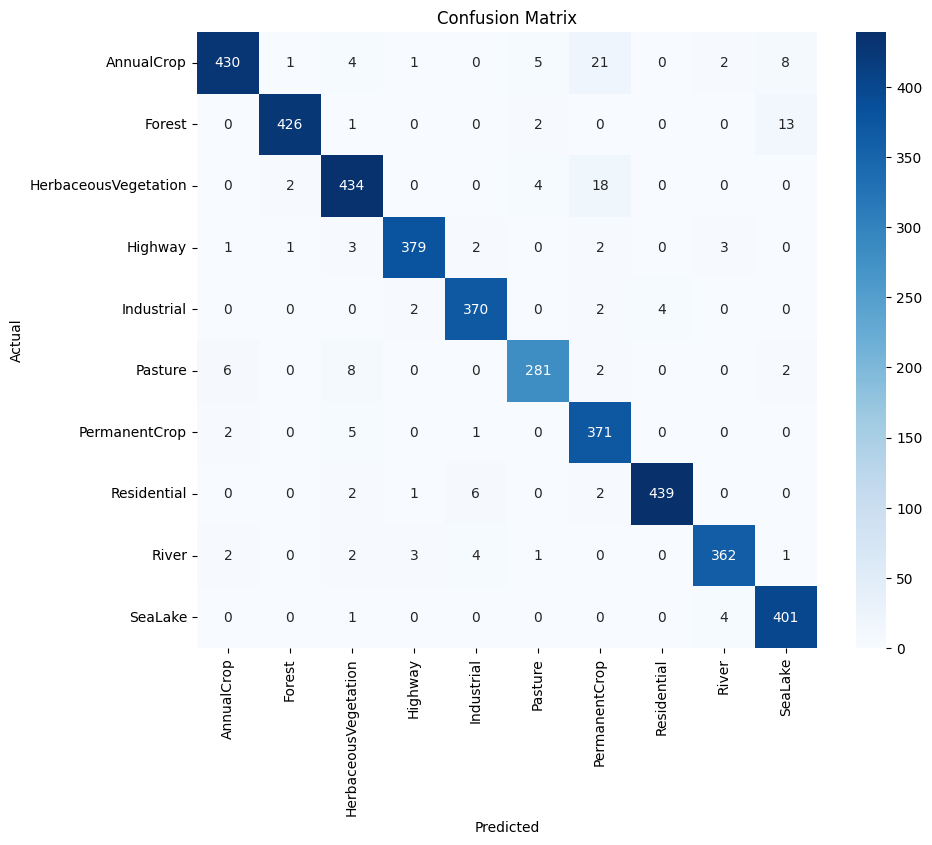

In [ ]:
# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## > Save Model

In [ ]:
# Save the trained model to a file
torch.save(model.state_dict(), 'mobilenetv2_eurosat.pth')